# ◆Students Performance in Exams
### 目的：学生のプロフィールから、数学のスコアを予測をする
### 目的変数を数学のスコアとする線形回帰問題としてRidge回帰アルゴリズムを使ったモデルを構築する
- kaggle URL:https://www.kaggle.com/spscientist/students-performance-in-exams
- Create Date：2020/01/06　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル構築
- Ridge回帰モデルを利用する

### 4.モデル評価
- MSE,RMSE,MAEを求める

### ※データセット
- 「StudentsPerformance.csv」（学習データ数：1000行8列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | gender | 性別 | - | - |
|  2 | race/ethnicity | 人種・民族 | - | ○ |
|  3 | parental level of education | 親の教育レベル | - | ○ |
|  4 | lunch | ランチ | - | - |
|  5 | test preparation course | 試験準備コース | - | ○ |
|  6 | math score | 数学のスコア | - | ○ |
|  7 | reading score | リーディングスコア | - | ○ |
|  8 | writing score | ライティングスコア | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import (LinearRegression,Ridge,Lasso)
# 警告非表示
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 関数：男女別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：',df[col_name].skew())
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['gender']=='male'][col_name],kde=True,rug=False,bins=bins_val,label='male')
    sns.distplot(df[df['gender']=='female'][col_name],kde=True,rug=False,bins=bins_val,label='female')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：男女別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の男子数と女子数（降順）')
        ax = sns.countplot(df[col_name],hue=df['gender'],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の男子数と女子数')
        ax = sns.countplot(df[col_name],hue=df['gender'])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：数学の平均点を比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_math_score_barplot(col_name, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df['math score'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('math score', ascending=False) # 成功率の降順
        print('\n▼ ' + str(col_name) + '別の数学の平均点（降順）')
    else:
        print('\n▼ ' + str(col_name) + '別の数学の平均点')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="math score", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('math score by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

## 1.データ読込

In [2]:
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
df = pd.read_csv('./StudentsPerformance.csv')

print('\n▼ データ数確認')
print('train data shape ---------> ' + str(df.shape))

print("\n▼ 先頭5行表示")
display(df.head(5))

print("\n▼ 基本統計量")
display(df.describe())

#print('\n▼ 欠損データ確認')
#display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))


▼ データ数確認
train data shape ---------> (1000, 8)

▼ 先頭5行表示


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75



▼ 基本統計量


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


## 2.データ前処理
### 2-1.欠損値の補完


▼ 散布図行列（男女別に色分け）


<Figure size 432x288 with 0 Axes>

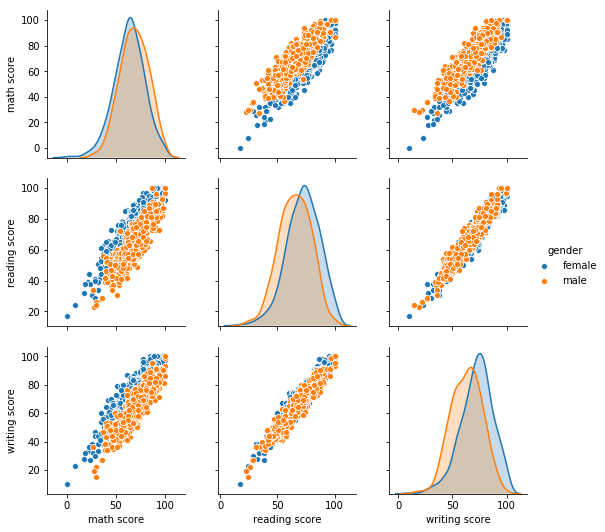

→数学とWriting/Readingよりも、とWritingとReadingが強い。また、男子のほうが数学が得意。

▼ 散布図行列（ランチ別に色分け）


<Figure size 432x288 with 0 Axes>

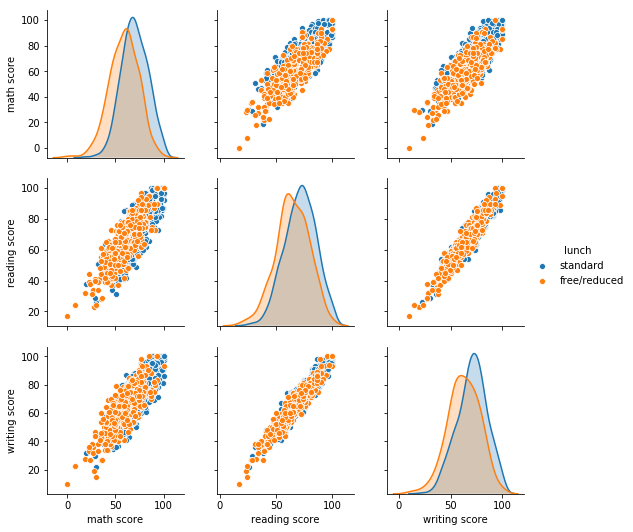

→ランチをとっている子のほうが高め

▼ 相関係数をヒートマップにして可視化


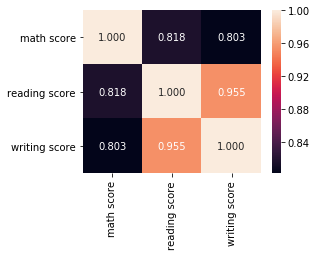


▼ 数学の平均値：
66.089


In [3]:
# ****************************************************************************
# ◆ 2.データ前処理
# ****************************************************************************

# ------------------------------------------------
# 2-1.相関関係の確認
# ------------------------------------------------
# 散布図行列
print('\n▼ 散布図行列（男女別に色分け）')
plt.figure(figsize=(6,4))
sns.pairplot(df, hue="gender")
plt.show()
print('→数学とWriting/Readingよりも、とWritingとReadingが強い。また、男子のほうが数学が得意。')

# 散布図行列
print('\n▼ 散布図行列（ランチ別に色分け）')
plt.figure(figsize=(6,4))
sns.pairplot(df, hue="lunch")
plt.show()
print('→ランチをとっている子のほうが高め')

# ヒートマップ
print('\n▼ 相関係数をヒートマップにして可視化')
plt.figure(figsize=(4,3))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()

print('\n▼ 数学の平均値：')
baseline = df['math score'].mean()
print(baseline)

### 2-2.前処理


▼ math scoreの分布 ※歪度： -0.27893514909431694


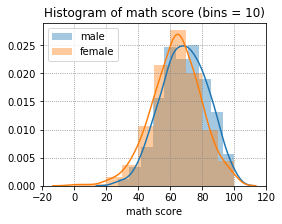


▼ reading scoreの分布 ※歪度： -0.25910451810923063


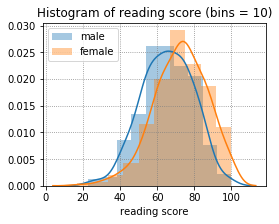


▼ writing scoreの分布 ※歪度： -0.28944397150761897


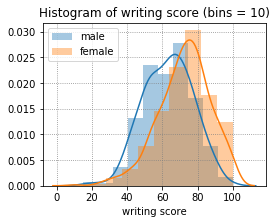

In [4]:
# ------------------------------------------------
# 2-2-1.各スコアの確認
# ------------------------------------------------
show_histogram('math score',4,3,10)
show_histogram('reading score',4,3,10)
show_histogram('writing score',4,3,10)


▼ gender別の男子数と女子数（降順）


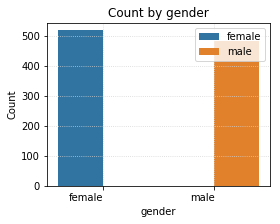


▼ gender別の数学の平均点（降順）


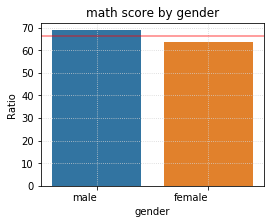


▼ race/ethnicity別の男子数と女子数（降順）


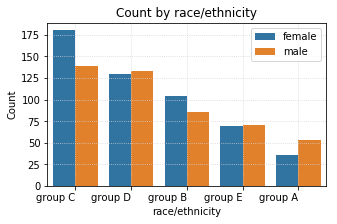


▼ race/ethnicity別の数学の平均点（降順）


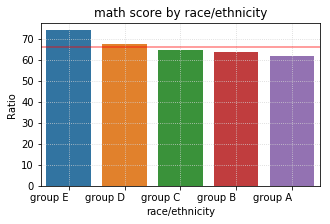


▼ parental level of education別の男子数と女子数（降順）


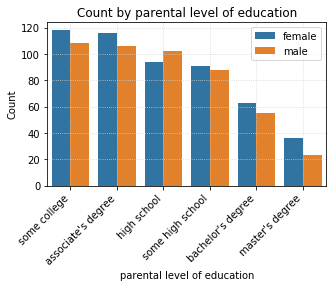


▼ parental level of education別の数学の平均点（降順）


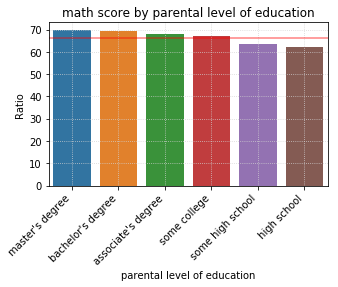


▼ lunch別の男子数と女子数（降順）


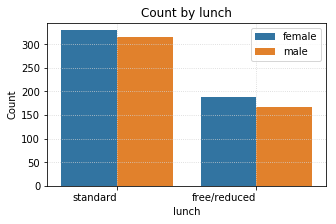


▼ lunch別の数学の平均点（降順）


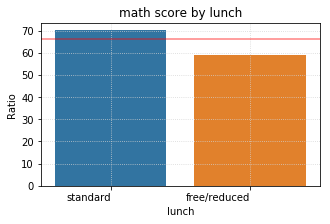


▼ test preparation course別の男子数と女子数（降順）


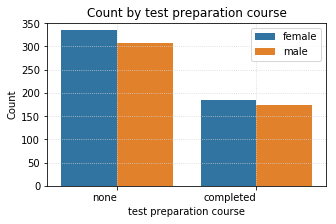


▼ test preparation course別の数学の平均点（降順）


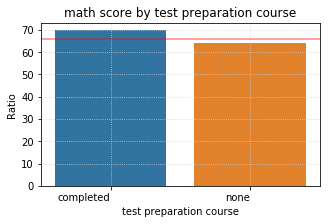

In [11]:
show_state_count_plot('gender',4,3,True)
show_math_score_barplot('gender',4,3,baseline,True)

show_state_count_plot('race/ethnicity',5,3,True)
show_math_score_barplot('race/ethnicity',5,3,baseline,True)

show_state_count_plot('parental level of education',5,3,True,45)
show_math_score_barplot('parental level of education',5,3,baseline,True,45)

show_state_count_plot('lunch',5,3,True)
show_math_score_barplot('lunch',5,3,baseline,True)

show_state_count_plot('test preparation course',5,3,True)
show_math_score_barplot('test preparation course',5,3,baseline,True)

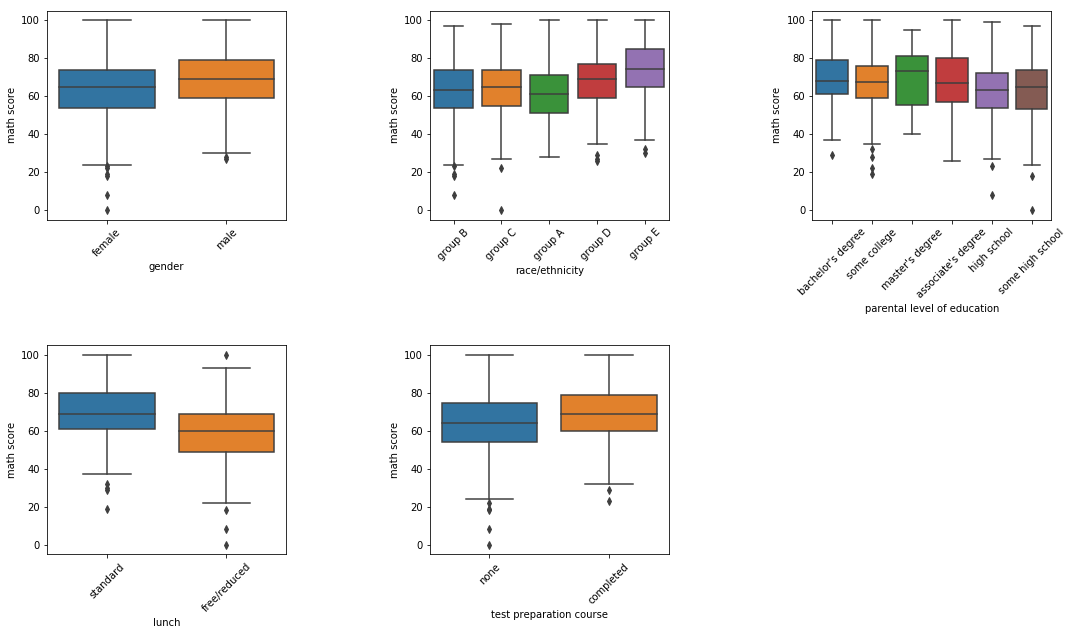

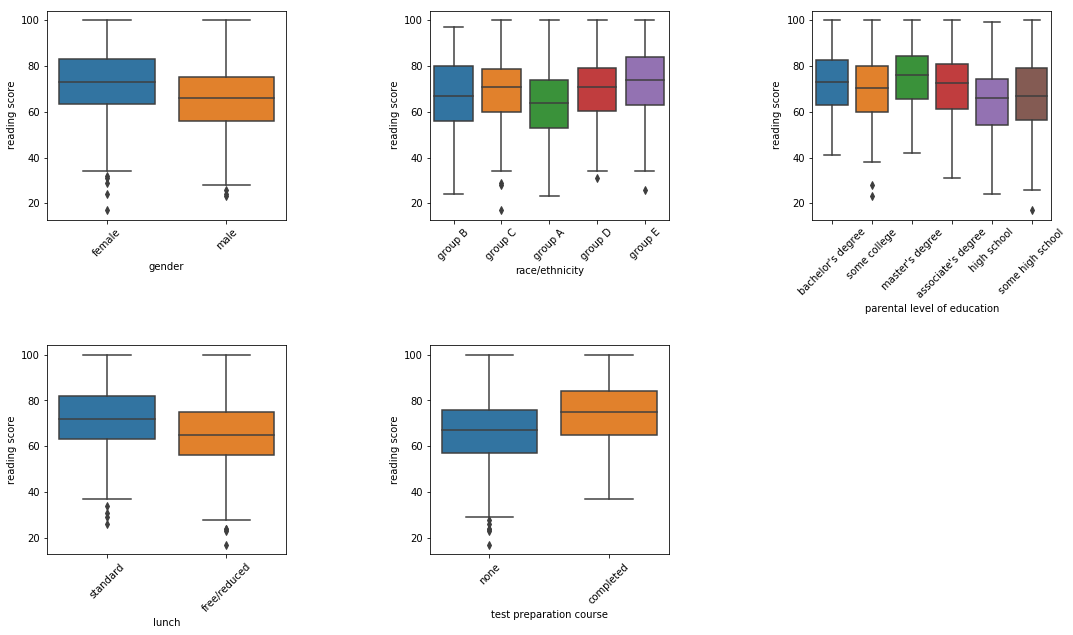

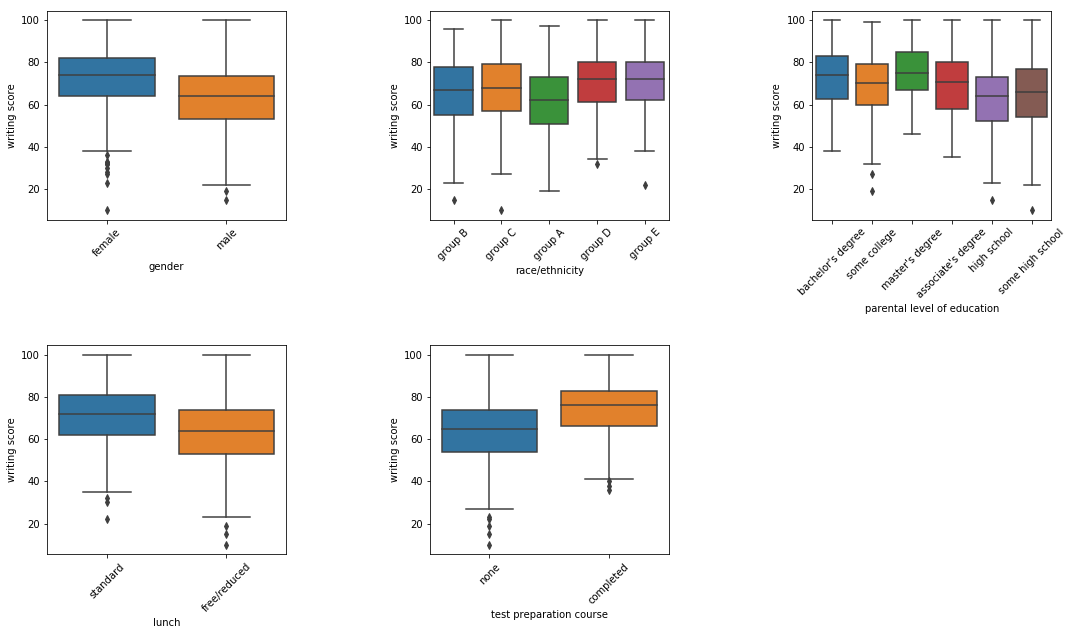

In [6]:
# ------------------------------------------------
# 2-2-3.テストの得点と学生のプロフィール情報の分布
# ------------------------------------------------
int_col = ['math score','reading score','writing score']
obj_col = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
for col_ in int_col:
    cnt = 0
    plt.figure(figsize=(18,10))
    for col in obj_col:
        plt.subplots_adjust(wspace=0.6, hspace=0.6) # 余白
        plt.subplot(2,3,cnt+1) # 2行3列
        sns.boxplot(x=col,y=col_,data=df)
        plt.xticks(rotation=45)
        cnt = cnt + 1

### 2-3.ダミー変換

In [7]:
# ------------------------------------------------
# 2-3.ダミー変換
# ------------------------------------------------
# ダミー変換
df_dummies = pd.get_dummies(df, columns=obj_col)

print("\n▼ 先頭データ5件")
display(df_dummies.head())


▼ 先頭データ5件


,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,72,72,74,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,69,90,88,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
2,90,95,93,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,47,57,44,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,76,78,75,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1


## 3.モデル構築


▼ ベストスコア
alpha : 10.0
test score is : 7.768

▼ 重みを表示（絶対値の降順：Top10）


,feature,weight
0,writing score,6.491
1,reading score,6.339
2,gender_female,-2.520
3,gender_male,2.520
4,race/ethnicity_group E,1.423
5,lunch_standard,1.339
6,lunch_free/reduced,-1.339
7,race/ethnicity_group A,-0.645
8,parental level of education_master's degree,-0.528
9,race/ethnicity_group C,-0.524


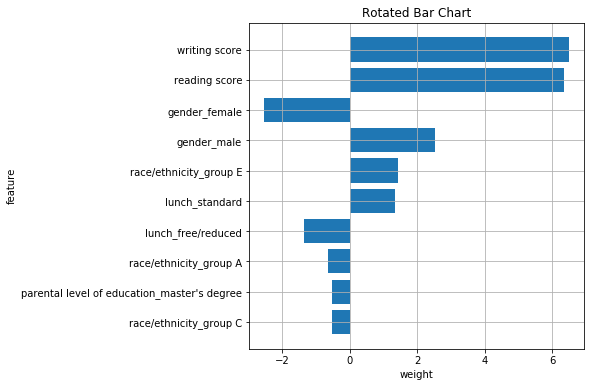

In [27]:
# ****************************************************************************
# ◆ 3.モデル構築
# ****************************************************************************
scaler = StandardScaler()  #スケーリング
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] #パラメータグリッド
cnt = 0

# 係数を求める
X = df_dummies.drop('math score', axis=1).values
y = df_dummies['math score'].values

# パラメータでループ
for alpha in param_grid:

    # Ridge回帰モデル
    ls = Ridge(alpha=alpha)
    
    #パイプライン生成
    pipeline = make_pipeline(scaler, ls) # 学習モデルインスタンス
    
    # ホールドアウト法
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
    
    # データを標準化
    X_train_norm = X_train
    X_test_norm = X_test

    # 先頭2列のデータを標準化
    X_train_norm[:,:2] = scaler.fit_transform(X_train[:,:2])
    X_test_norm[:,:2] = scaler.transform(X_test[:,:2])
    
    # 学習
    pipeline.fit(X_train_norm,y_train)

    # 学習データのRMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train_norm)))
    
    # テストデータのRMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test_norm)))
    
    if cnt == 0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        # より小さいRMSEを見つけた場合
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1
    
print('\n▼ ベストスコア')
print('alpha : ' + str(best_param))
print('test score is : {:.3f}'.format(best_score))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(df_dummies.drop('math score', axis=1).columns)
res_df['weight'] = best_estimator.steps[-1][1].coef_.ravel() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
print('\n▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
plt.figure(figsize=(6, 6))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

## 4.モデル評価


▼ モデルの検証


<Figure size 432x288 with 0 Axes>

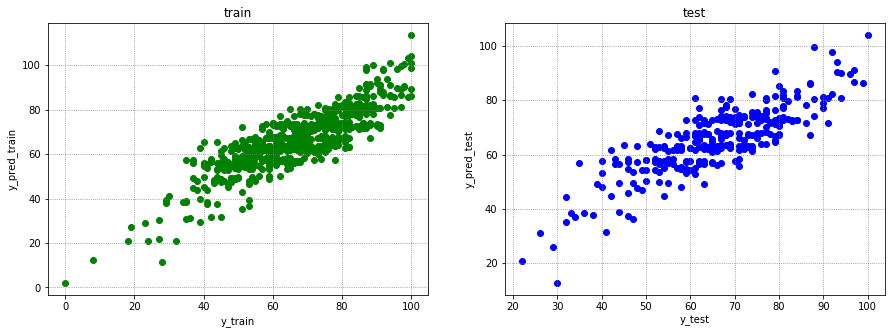


▼ モデルの評価結果
['57.78', '67.11', '48.06', '68.44', '62.82', '72.04', '62.23', '54.52', '86.28', '37.27', '44.58']
['62.00', '87.00', '40.00', '77.00', '69.00', '78.00', '67.00', '46.00', '99.00', '46.00', '54.00']

平均二乗和誤差(MSE) = 60.338

平均絶対値誤差(MAE) = 6.355

平方根平均二乗和誤差(RMSE) = 7.768


In [17]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************
print('\n▼ モデルの検証')
# 学習したモデルが実際に教師データにどれくらい近似できているのか
# 横軸が教師データ、縦軸が予測結果としてデータを散布
plt.subplots_adjust(wspace=0.8) # 余白
plt.figure(figsize=(15,5))

# 学習データ
plt.subplot(121) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.scatter(y_train, best_estimator.predict(X_train_norm), c='green')
plt.title('train')
plt.xlabel('y_train')
plt.ylabel('y_pred_train')
plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')


# テストデータ
plt.subplot(122) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.scatter(y_test, best_estimator.predict(X_test_norm), c='blue')
plt.title('test')
plt.xlabel('y_test')
plt.ylabel('y_pred_test')
plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')

plt.show()

# 予測
y_test_pred = best_estimator.predict(X_test)

print('\n▼ モデルの評価結果')
print(['{:.2f}'.format(n) for n in y_test_pred[:11]])
print(['{:.2f}'.format(n) for n in y_test[:11]])

# 二乗誤差(MSE)を計算
mse = mean_squared_error(y_test, y_test_pred) 
print("\n平均二乗和誤差(MSE) = %s"%round(mse,3) )  

# 絶対値誤差(MAE)を計算
mae = mean_absolute_error(y_test, y_test_pred) 
print("\n平均絶対値誤差(MAE) = %s"%round(mae,3) )

# 平方根二乗誤差(RMSE)を計算
rmse = np.sqrt(mse)
print("\n平方根平均二乗和誤差(RMSE) = %s"%round(rmse, 3) )